# Classifiers

In [2]:
# Core Libraries
import os
import glob
import itertools

# Data Handling
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Progress Bar
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Statistics
from scipy.stats import skew, kurtosis, randint

# Modeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression


In [3]:
df_a =pd.read_parquet('data/set_a_for_q2_1.parquet', engine='pyarrow')
df_b =pd.read_parquet('data/set_b_for_q2_1.parquet', engine='pyarrow')
df_c =pd.read_parquet('data/set_c_for_q2_1.parquet', engine='pyarrow')



In [4]:
static_variables = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']

if 'ICUType' not in df_a.columns: static_variables.remove('ICUType')

static_variables_we_want = ['Age', 'Gender', 'Height', 'Weight']
all_variables = ['Weight', 'Age', 'TroponinI', 'DiasABP', 'MechVent', 'HCO3', 'Cholesterol', 'HCT', 'SaO2', 'WBC', 'SysABP', 'Urine', 'ICUType', 'Gender', 'ALP', 'Creatinine', 'K', 'AST', 'Glucose', 'RespRate', 'MAP', 'FiO2', 'BUN', 'Na', 'Bilirubin', 'TroponinT', 'PaCO2', 'Height', 'GCS', 'HR', 'pH', 'PaO2', 'Lactate', 'ALT', 'NISysABP', 'RecordID', 'Platelets', 'Temp', 'Mg', 'NIDiasABP', 'Albumin', 'NIMAP']
dyn_variables = [x for x in all_variables if x not in static_variables]
dyn_variables.append('Weight_VAR')
len(dyn_variables), len(static_variables_we_want)

(38, 4)

In [5]:
assert df_a.isnull().sum().sum() == 0
assert df_b.isnull().sum().sum() == 0
assert df_c.isnull().sum().sum() == 0

In [6]:
# load outcomes.csv file into a dict where RecordID is the key and In-hospital_death is the value
outcomes = pd.read_csv('data/outcomes.csv')

outcomes_a = outcomes.loc[outcomes['RecordID'].isin(df_a['RecordID'])]
outcomes_b = outcomes.loc[outcomes['RecordID'].isin(df_b['RecordID'])]
outcomes_c = outcomes.loc[outcomes['RecordID'].isin(df_c['RecordID'])]

## Random forest


Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations.

In [7]:
# --- Utility Functions ---
def evaluate_model(model, X, y_true, title_info=None):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix, " + (title_info if title_info else ""))
    plt.show()

    roc_auc = roc_auc_score(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    return roc_auc, avg_precision

def train_rf(X_train, y_train, **kwargs):
    rf = RandomForestClassifier(random_state=42, **kwargs)
    rf.fit(X_train, y_train)
    return rf


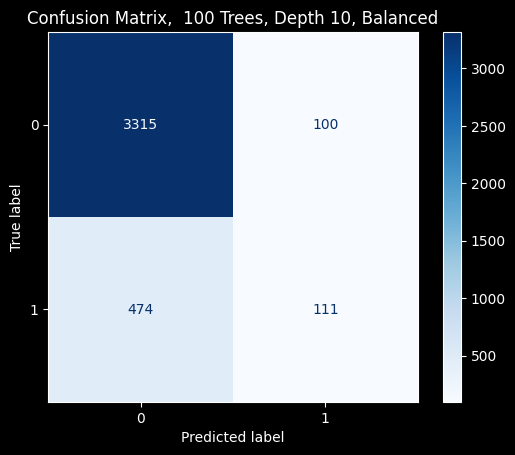

ROC AUC Score: 0.8233
Average Precision Score: 0.4305


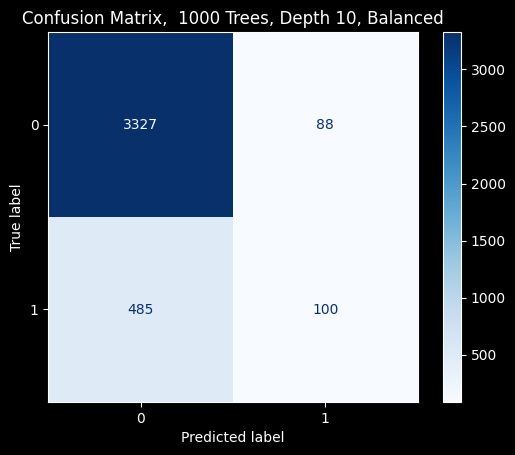

ROC AUC Score: 0.8353
Average Precision Score: 0.4482


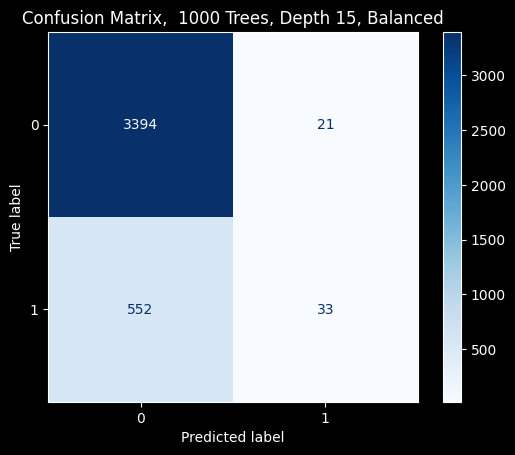

ROC AUC Score: 0.8338
Average Precision Score: 0.4481


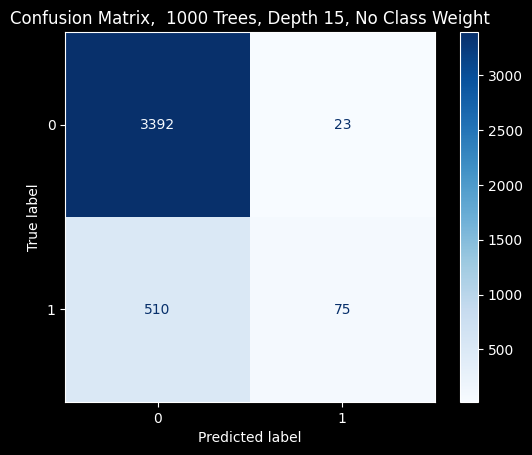

ROC AUC Score: 0.8153
Average Precision Score: 0.4799


(np.float64(0.8153245485602733), np.float64(0.4799280154487922))

In [8]:

# --- We Run a Few Models with Varying Parameters ---
feature_cols = [col for col in df_a.columns if col != 'RecordID']

# Model 1
rf1 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=100, max_depth=10, class_weight='balanced')
evaluate_model(rf1, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 100 Trees, Depth 10, Balanced')

# Model 2
rf2 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=1000, max_depth=10, class_weight='balanced')
evaluate_model(rf2, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 1000 Trees, Depth 10, Balanced')

# Model 3
rf3 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=1000, max_depth=15, class_weight='balanced')
evaluate_model(rf3, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 1000 Trees, Depth 15, Balanced')

# Model 4
rf4 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=1000, max_depth=15, class_weight=None)
evaluate_model(rf4, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 1000 Trees, Depth 15, No Class Weight')


In [9]:
# --- Randomized Hyperparameter Search ---
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 20),
    'max_samples': [0.5, 0.75, 1.0],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5), #limit complexity by limiting nb leaf in tree
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,  
    cv =3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(df_a[feature_cols], outcomes_a['In-hospital_death'])

print("\nBest parameters from random search:")
print(random_search.best_estimator_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

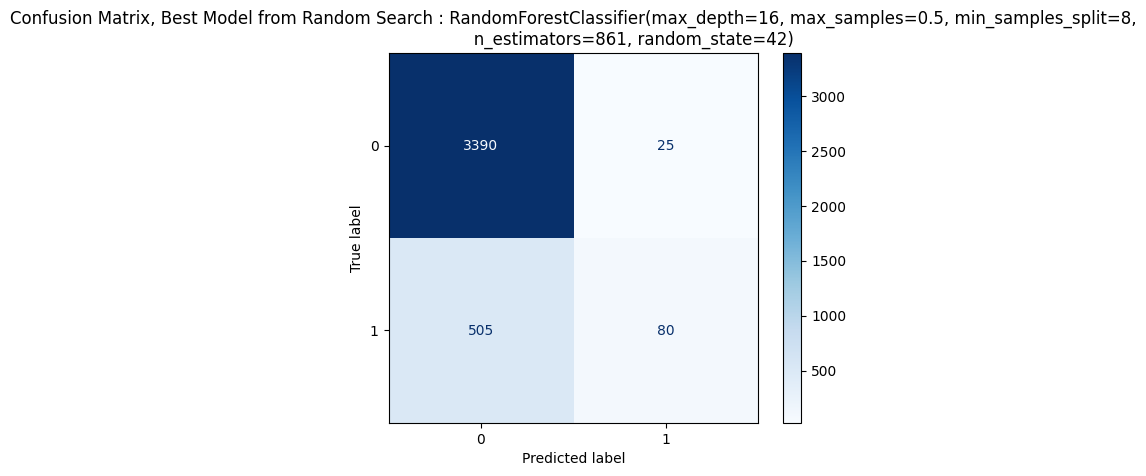

ROC AUC Score: 0.8109
Average Precision Score: 0.4792


(0.8109491809638223, 0.47918718989917636)

In [ ]:
# --- Evaluate Best Model ---
best_rf = random_search.best_estimator_
evaluate_model(best_rf, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info=f'Best Model from Random Search : {random_search.best_estimator_}')

## Logistic  regression - Standard Scaler

In [ ]:
# --- scaling Data ---
feature_cols = [col for col in df_a.columns if col != 'RecordID']

scaler = StandardScaler()
scaler.fit(df_a[feature_cols])

df_a_scaled = pd.DataFrame(scaler.transform(df_a[feature_cols]), columns=feature_cols)
df_b_scaled = pd.DataFrame(scaler.transform(df_b[feature_cols]), columns=feature_cols)
df_c_scaled = pd.DataFrame(scaler.transform(df_c[feature_cols]), columns=feature_cols)


In [ ]:
np.logspace(-3,3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [ ]:

# --- Grid Search for Best Regularization ---
# C = inverse of regularization strength, smaller values => stronger regularization

param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=600, class_weight='balanced'),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(df_a_scaled, outcomes_a['In-hospital_death'])

best_log_reg = grid.best_estimator_
print("Best C:", grid.best_params_['C'])



Best C: 0.1


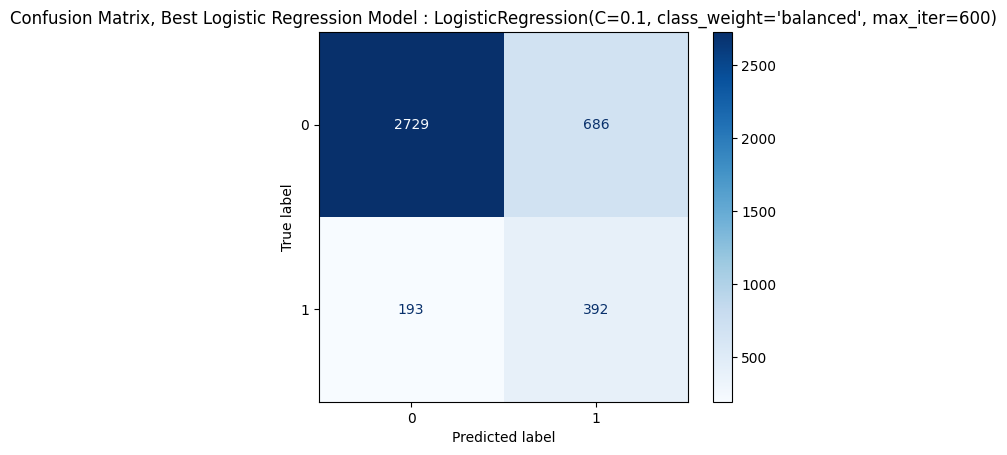

ROC AUC Score: 0.8082
Average Precision Score: 0.4308


(0.80822414936617, 0.430815399661236)

In [ ]:
# --- Prediction on Test Set ---
evaluate_model(best_log_reg, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model : {grid.best_estimator_}')

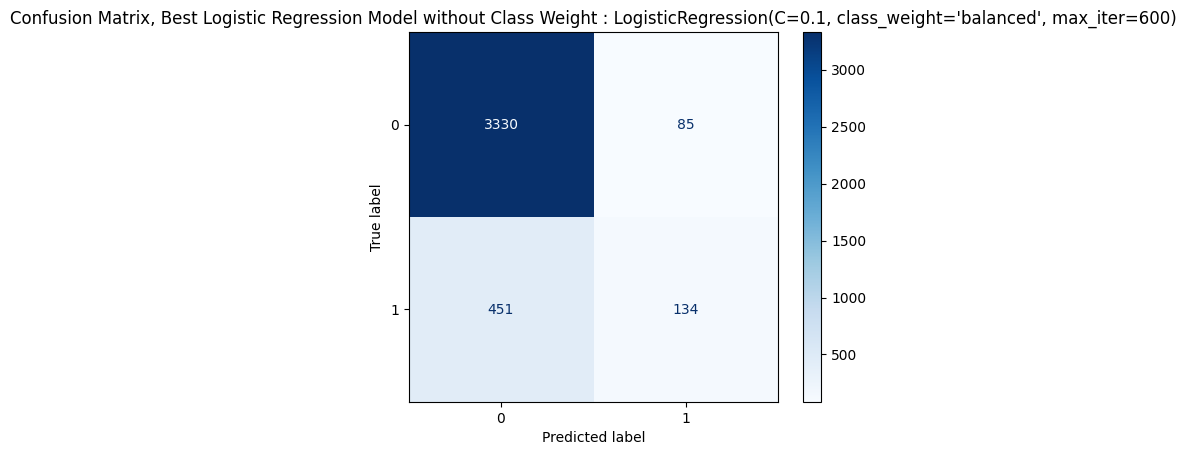

ROC AUC Score: 0.8263
Average Precision Score: 0.4617


(0.826305264606875, 0.46170315645851895)

In [ ]:
# model = best log reg but with no class weight
best_log_reg_no_weight = LogisticRegression(max_iter=600, C=grid.best_params_['C'])
best_log_reg_no_weight.fit(df_a_scaled, outcomes_a['In-hospital_death'])

evaluate_model(best_log_reg_no_weight, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model without Class Weight : {grid.best_estimator_}')

## Logistic  regression - MinMax scaler


Best C: 10.0


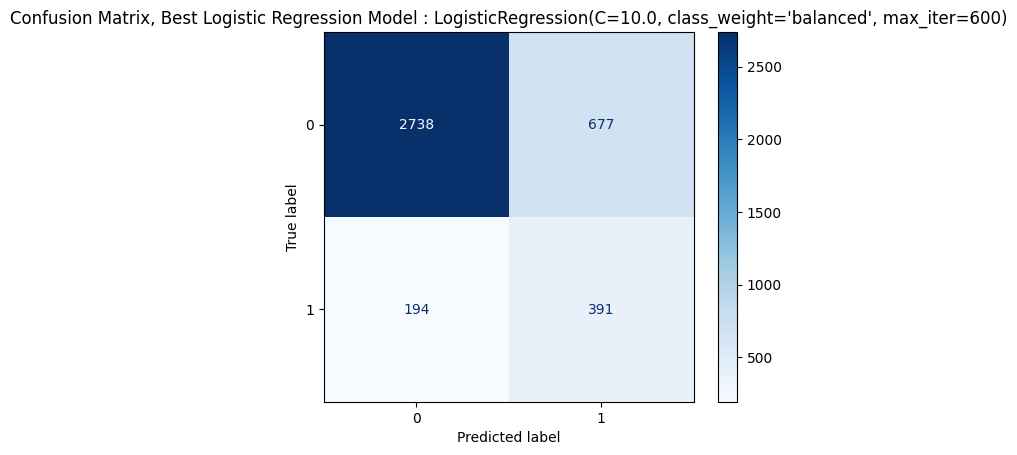

ROC AUC Score: 0.8071
Average Precision Score: 0.4287


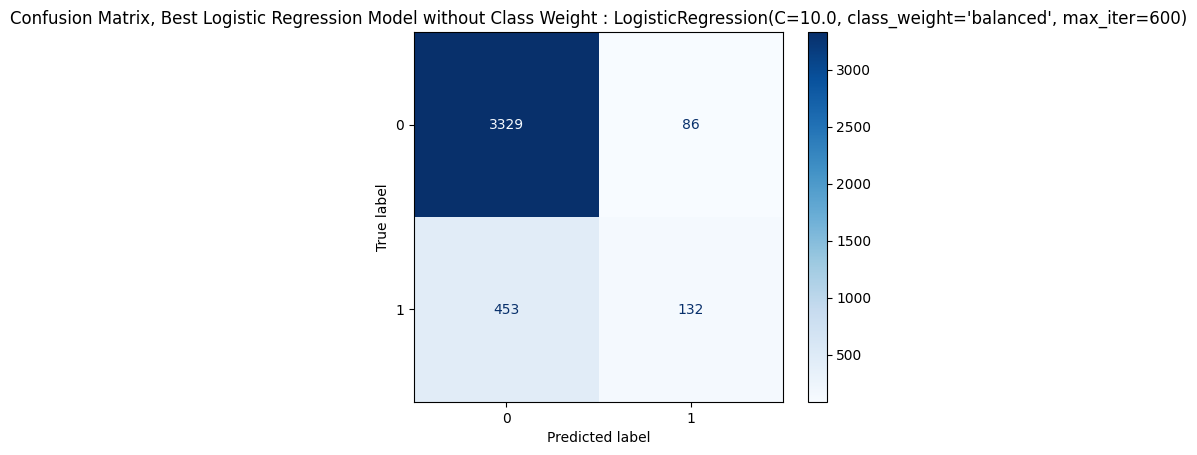

ROC AUC Score: 0.8238
Average Precision Score: 0.4585


(0.8237514234585976, 0.45853354329534574)

In [ ]:

# --- scaling Data ---
feature_cols = [col for col in df_a.columns if col != 'RecordID']

scaler = MinMaxScaler()
scaler.fit(df_a[feature_cols])

df_a_scaled = pd.DataFrame(scaler.transform(df_a[feature_cols]), columns=feature_cols)
df_b_scaled = pd.DataFrame(scaler.transform(df_b[feature_cols]), columns=feature_cols)
df_c_scaled = pd.DataFrame(scaler.transform(df_c[feature_cols]), columns=feature_cols)

np.logspace(-3,3, 7)

# --- Grid Search for Best Regularization ---
# C = inverse of regularization strength, smaller values => stronger regularization

param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=600, class_weight='balanced'),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(df_a_scaled, outcomes_a['In-hospital_death'])

best_log_reg = grid.best_estimator_
print("Best C:", grid.best_params_['C'])


# --- Prediction on Test Set ---
evaluate_model(best_log_reg, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model : {grid.best_estimator_}')
# model = best log reg but with no class weight
best_log_reg_no_weight = LogisticRegression(max_iter=600, C=grid.best_params_['C'])
best_log_reg_no_weight.fit(df_a_scaled, outcomes_a['In-hospital_death'])

evaluate_model(best_log_reg_no_weight, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model without Class Weight : {grid.best_estimator_}')
